In [80]:
# Build neural network

# read training data
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

#df = pd.Dataframe()
df_train = pd.read_csv('./measuring-customer-happiness/train_hp.csv', encoding='utf-8')
print(df_train.head(3))

#df_test = pd.read_csv('./measuring-customer-happiness/test_hp.csv', encoding='utf-8')
#print(df_test.head(3))

   User_ID                                        Description  \
0  id10326  The room was kind of clean but had a VERY stro...   
1  id10327  I stayed at the Crown Plaza April -- - April -...   
2  id10328  I booked this hotel through Hotwire at the low...   

        Browser_Used Device_Used Is_Response  
0               Edge      Mobile   not happy  
1  Internet Explorer      Mobile   not happy  
2            Mozilla      Tablet   not happy  


In [81]:
df_train = df_train[['Description', 'Is_Response']]
print(df_train.head())

                                         Description Is_Response
0  The room was kind of clean but had a VERY stro...   not happy
1  I stayed at the Crown Plaza April -- - April -...   not happy
2  I booked this hotel through Hotwire at the low...   not happy
3  Stayed here with husband and sons on the way t...       happy
4  My girlfriends and I stayed here to celebrate ...   not happy


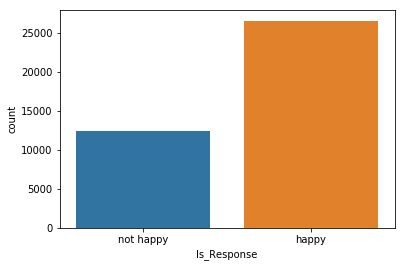

In [82]:
import seaborn as sns

sns.countplot(x='Is_Response', data=df_train)

In [83]:
# Data Preprocessing

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

X = []
sentences = list(df_train['Description'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [84]:
X[3]


'Stayed here with husband and sons on the way to an Alaska Cruise We all loved the hotel great experience Ask for room on the North tower facing north west for the best views We had high floor with stunning view of the needle the city and even the cruise ships We ordered room service for dinner so we could enjoy the perfect views Room service dinners were delicious too You are in perfect spot to walk everywhere so enjoy the city Almost forgot Heavenly beds were heavenly too '

In [85]:
# binary classification for happy and not_happy 

y = df_train['Is_Response']

y = np.array(list(map(lambda x: 1 if x=="happy" else 0, y)))

# 1) Simple Neural Network

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [87]:
# Prepare embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [88]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [89]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.twitter.27B/glove.twitter.27B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [90]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [91]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [92]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          4154400   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 4,164,401
Trainable params: 10,001
Non-trainable params: 4,154,400
_________________________________________________________________
None


# Model training

In [93]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 24916 samples, validate on 6229 samples
Epoch 1/6
24916/24916 [==============================] - 1s 56us/step - loss: 0.4898 - acc: 0.7632 - val_loss: 0.4415 - val_acc: 0.7952
Epoch 2/6
24916/24916 [==============================] - 0s 19us/step - loss: 0.3901 - acc: 0.8263 - val_loss: 0.4521 - val_acc: 0.7908
Epoch 3/6
24916/24916 [==============================] - 1s 20us/step - loss: 0.3549 - acc: 0.8442 - val_loss: 0.4448 - val_acc: 0.7995
Epoch 4/6
24916/24916 [==============================] - 1s 24us/step - loss: 0.3275 - acc: 0.8607 - val_loss: 0.4617 - val_acc: 0.7931
Epoch 5/6
24916/24916 [==============================] - 1s 23us/step - loss: 0.3114 - acc: 0.8698 - val_loss: 0.4645 - val_acc: 0.7952
Epoch 6/6
24916/24916 [==============================] - 1s 23us/step - loss: 0.2959 - acc: 0.8745 - val_loss: 0.4773 - val_acc: 0.7934


# Evaluation of model 

In [94]:
score = model.evaluate(X_test, y_test, verbose=1)

7787/7787 [==============================] - 0s 22us/step


In [95]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.47720543489661926
Test Accuracy: 0.7883652240761256


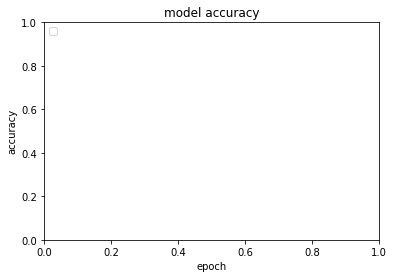

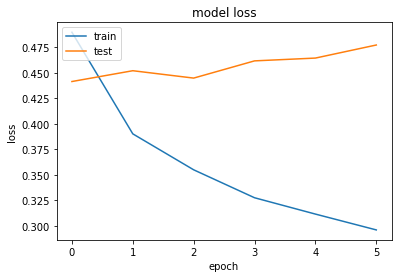

In [96]:
import matplotlib.pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# 2) Convolutional Neural Network

In [97]:
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [98]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          4154400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 4,218,657
Trainable params: 64,257
Non-trainable params: 4,154,400
_________________________________________________________________
None


# Model Training & Evaluation 

In [99]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 24916 samples, validate on 6229 samples
Epoch 1/6
24916/24916 [==============================] - 8s 336us/step - loss: 0.4366 - acc: 0.7990 - val_loss: 0.3690 - val_acc: 0.8342
Epoch 2/6
24916/24916 [==============================] - 8s 304us/step - loss: 0.3279 - acc: 0.8604 - val_loss: 0.3478 - val_acc: 0.8427
Epoch 3/6
24916/24916 [==============================] - 7s 293us/step - loss: 0.2809 - acc: 0.8853 - val_loss: 0.3360 - val_acc: 0.8534
Epoch 4/6
24916/24916 [==============================] - 7s 281us/step - loss: 0.2454 - acc: 0.9037 - val_loss: 0.3334 - val_acc: 0.8541
Epoch 5/6
24916/24916 [==============================] - 7s 289us/step - loss: 0.2145 - acc: 0.9187 - val_loss: 0.3321 - val_acc: 0.8552
Epoch 6/6
7787/7787 [==============================] - 1s 129us/step


In [100]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3286785057929938
Test Accuracy: 0.860793630447929


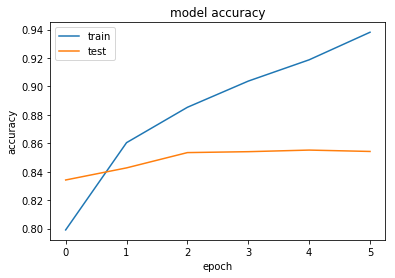

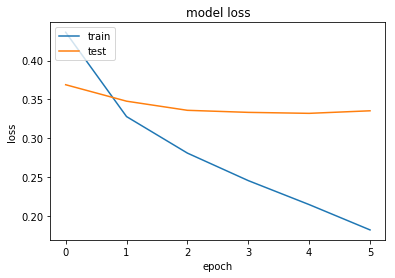

In [101]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# 3) Recurrent Neural Network: LSTM (Long Short Term Memory network)

In [102]:
from keras.layers.recurrent import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [103]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          4154400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 4,271,777
Trainable params: 117,377
Non-trainable params: 4,154,400
_________________________________________________________________
None


# Model Training & Evaluation 

In [104]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)


Train on 24916 samples, validate on 6229 samples
Epoch 1/6
24916/24916 [==============================] - 34s 1ms/step - loss: 0.5112 - acc: 0.7520 - val_loss: 0.4660 - val_acc: 0.7926
Epoch 2/6
24916/24916 [==============================] - 32s 1ms/step - loss: 0.4230 - acc: 0.8068 - val_loss: 0.3943 - val_acc: 0.8191
Epoch 3/6
24916/24916 [==============================] - 31s 1ms/step - loss: 0.3841 - acc: 0.8319 - val_loss: 0.3687 - val_acc: 0.8406
Epoch 4/6
24916/24916 [==============================] - 32s 1ms/step - loss: 0.3534 - acc: 0.8483 - val_loss: 0.3466 - val_acc: 0.8476
Epoch 5/6
24916/24916 [==============================] - 33s 1ms/step - loss: 0.3400 - acc: 0.8548 - val_loss: 0.3431 - val_acc: 0.8546
Epoch 6/6
7787/7787 [==============================] - 4s 496us/step


In [105]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3474846947510037
Test Accuracy: 0.8462822653446024


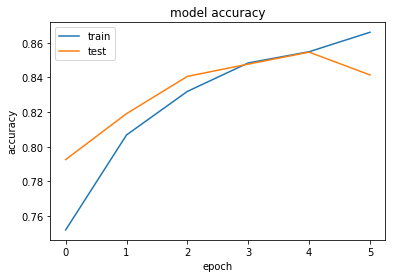

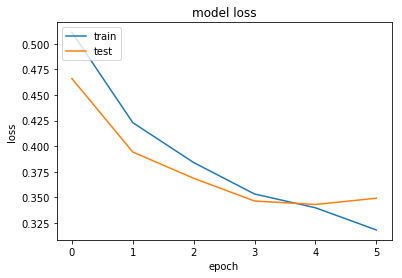

In [106]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# Predict sentiments

In [107]:
instance = X[57]
print(instance)

horrible hotel staff treated me with disgusting demeaning attitude THEY WILL NOT ONLY BE REPORTED TO CHOICE and m elite diamond but WILL NEVER EVER GO NEAR THIS HOTEL AGAIN left saying my stay was just ok would rather report them to their franchise than deal with them as they clearly don care about their guests Ironically their horrible way of manging this hotel and dealing with guests surely has got to hurt their business Treating your guests with respect makes them want to return and spend more duh cannot recommend this hotel based on my experience here Their rooms are disgusting and have bed bugs 


####  - convert review into numeric form (using the tokenizer)
####  - text_to_sequences method will convert the sentence into its numeric counter part
####  - positive = 1, negative = 0
####  - sigmoid function predicts floating value between 0 and 1. 
####  - value < 0.5 = negative sentiment 
####  - value > 0.5 = positive sentiment 


In [108]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.7697574]], dtype=float32)